# Linear Equation Systems

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg

The most important application of sparse matrices is arguably to solve linear equation
system on the form $Ax = b$, where $A$ is a sparse matrix and $x$ and $b$ are dense vectors.
The SciPy `sparse.linalg` module has both direct and iterative solver for this type of
problem (`sp.linalg.spsolve`) and methods to factor a matrix $A$, using, for example,
$LU$ factorization (`sp.linalg.splu`) and incomplete $LU$ factorization (`sp.linalg.spilu`).
For example, consider the problem $Kx = b$ where $K$ is the tridiagonal matrix considered
in the preceding text and $b$ is a dense vector filled with negative ones (see Chapter 11
for a physical interpretation of this equation). To solve this problem for the system size
10 × 10, we first create the sparse matrix $K$ and the dense vector $b$

In [2]:
N = 10
K = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format="csc")
b = -np.ones(N)

Now, to solve the equation system using the direct solver provided by SciPy,
we can use

In [3]:
%time

x = sp.linalg.spsolve(K, b)

x

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.29 µs


array([ 5.,  9., 12., 14., 15., 15., 14., 12.,  9.,  5.])

The solution vector is a dense NumPy array. For comparison, we can also solve
this problem using dense direct solver in NumPy `np.linalg.solve` (or, similarly, using
`scipy.linalg.solve`). To be able to use the dense solver, we need to convert the sparse
matrix $A$ to a dense array using `A.todense()`

In [4]:
%time

np.linalg.solve(K.todense(), b)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.58 µs


array([ 5.,  9., 12., 14., 15., 15., 14., 12.,  9.,  5.])

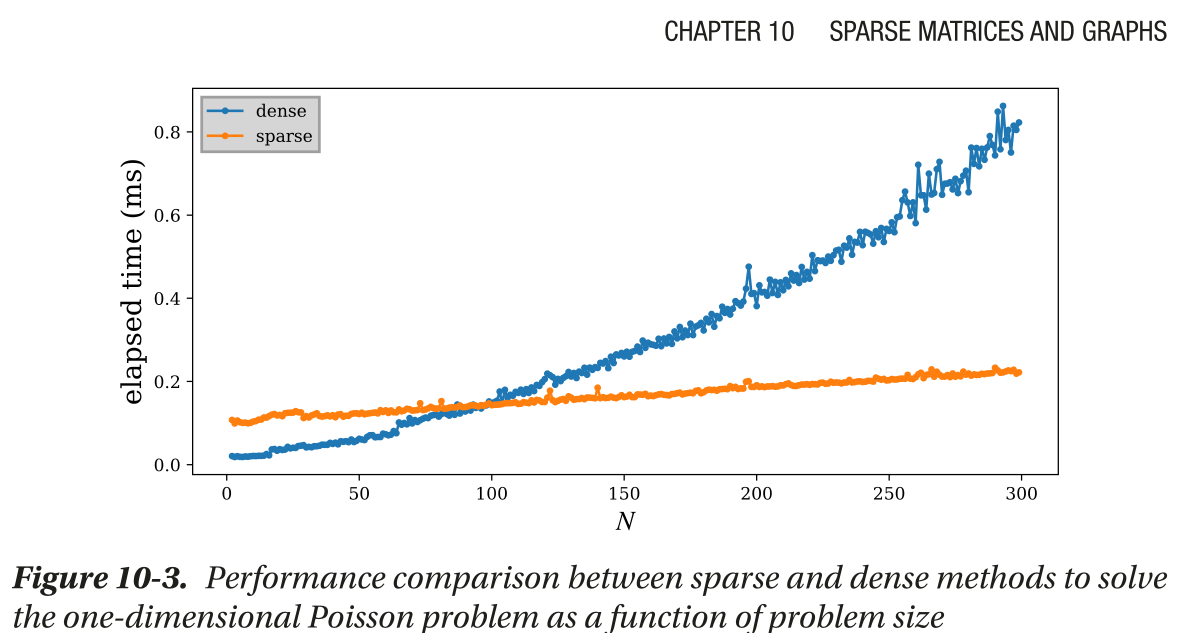

An alternative to the `spsolve` interface is to explicitly compute the $LU$ factorization
using `sp.sparse.splu` or `sp.sparse.spilu` (incomplete $LU$ factorization). These
functions return an object that contains the $L$ and $U$ factors and that has a method that
solves $LUx = b$ for a given vector $b$. This is of course particularly useful when the $Ax = b$
has to be solved for multiple vectors $b$. For example, the $LU$ factorization of the matrix $K$
used previously is computed using

In [5]:
lu = sp.linalg.splu(K)

lu.L

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Column format>

In [6]:
lu.U

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Column format>

Once the $LU$ factorization is available, we can efficiently solve the equation $LUx = b$
using the solve method for the `lu` object

In [7]:
x = lu.solve(b)
x

array([ 5.,  9., 12., 14., 15., 15., 14., 12.,  9.,  5.])

An important consideration that arises with sparse matrices is that the $LU$
factorization of $A$ may introduce new nonzero elements in $L$ and $U$ compared to the
matrix $A$ and therefore make $L$ and $U$ less sparse. Elements that exist in $L$ or $U$, but
not in $A$, are called fill-ins. If the amount of fill-ins is large, the advantage of using
sparse matrices may be lost. While there is no complete solution to eliminate fill-ins,
it is often possible to reduce fill-in by permuting the rows and columns in $A$, so that
the $LU$ factorization takes the form $P_rAP_c = LU$, where $P_r$ and $P_c$ are row and column
permutation matrices, respectively. Several such methods for permutations methods are
available. The `spsolve`, `splu`, and `spilu` functions all take the argument `permc_spec`,
which can take the values `NATURAL`, `MMD_ATA`, `MMD_AT_PLUS_A`, or `COLAMD`, which indicates
different permutation methods that are built into these methods. The object returned
by `splu` and `spilu` accounts for such permutations, and the permutation vectors are
available via the `perm_c` and `perm_r` attributes. Because of these permutations, the
product of `lu.L` and `lu.U` is not directly equal to $A$, and to reconstruct $A$ from `lu.L` and
`lu.U`, we also need to undo the row and column permutations

In [8]:
def sp_permute(A, perm_r, perm_c):
    """permute rows and columns of A"""
    M, N = A.shape
    # row permutation matrix
    Pr = sp.coo_matrix((np.ones(M), (perm_r, np.arange(N)))).tocsr()
    # column permutation matrix
    Pc = sp.coo_matrix((np.ones(M), (np.arange(M), perm_c))).tocsr()
    return Pr.T * A * Pc.T

#### Explanation

In [9]:
# Not equals zero, not the same!
lu.L * lu.U - K

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Column format>

In [10]:
# Equals zero, same!
sp_permute(lu.L * lu.U, lu.perm_r, lu.perm_c) - K

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Column format>

In [11]:
# Row idxs for permutation
lu.perm_r

array([0, 1, 2, 3, 4, 5, 6, 8, 7, 9], dtype=int32)

In [12]:
# Col idxs for permutation
lu.perm_c

array([0, 1, 2, 3, 4, 5, 6, 8, 7, 9], dtype=int32)

Values for the row permutation matrix: `np.ones(10)`

(Row idxs, Col idxs): `(lu.perm_r, np.arange(10))`

In [13]:
sp.coo_matrix((np.ones(10), (lu.perm_r, np.arange(10)))).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Values for the col permutation matrix: `np.ones(10)`

(Col idxs, Row idxs): `(lu.perm_c, np.arange(10))`

In [14]:
sp.coo_matrix((np.ones(10), (np.arange(10), lu.perm_c))).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

The `sp.spsolve` function is an interface to direct solvers, which internally performs
matrix factorization. An alternative approach is to use iterative methods that originate
in optimization. The SciPy `sparse.linalg` module contains several functions for the
iterative solution of sparse linear problems: for example, `bicg` (biconjugate gradient
method), `bicgstab` (biconjugate gradient stabilized method), `cg` (conjugate gradient),
`gmres` (generalized minimum residual), and `lgmres` (loose generalized minimum
residual method). All of these functions (and a few others) can be used to solve the
problem $Ax = b$ by calling the function with $A$ and $b$ as arguments, and they all return a
tuple `(x, info)` where `x` is the solution and info contains additional information about
the solution process (`info=0` indicates success, and it is positive for convergence error
and negative for input error). For example

In [15]:
x, info = sp.linalg.bicgstab(K, b, atol=1e-4)

x, info

(array([ 5.,  9., 12., 14., 15., 15., 14., 12.,  9.,  5.]), 0)

In [16]:
x, info = sp.linalg.lgmres(K, b, atol=1e-4)

x, info

(array([ 5.,  9., 12., 14., 15., 15., 14., 12.,  9.,  5.]), 0)

## Eigenvalue Problems

Sparse eigenvalue and singular-value problems can be solved using the `sp.linalg.eigs`
and `sp.linalg.svds` functions, respectively. For real symmetric or complex Hermitian
matrices, the eigenvalues (which in this case are real) and eigenvectors can also be
computed using `sp.linalg.eigsh`. These functions do not compute all eigenvalues
or singular values, but rather compute a given number of eigenvalues and vectors (the
default is six). Using the keyword argument `k` with these functions, we can define how
many eigenvalues and vectors should be computed. Using the which keyword argument,
we can specify which `k` values are to be computed. The options for eigs are the largest
magnitude $LM$, smallest magnitude $SM$, largest real part $LR$, smallest real part $SR$, largest
imaginary part $LI$, and smallest imaginary part $SI$. For `svds` only $LM$ and $SM$ are available.
For example, to compute the lowest four eigenvalues for the sparse matrix of the
one-dimensional Poisson problem (of system size 10x10), we can use `sp.linalg.eigs(A, k=4, which='LM')`

In [17]:
N = 10
K = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format="csc")

evals, evecs = sp.linalg.eigs(K, k=4, which="LM")
evals

array([-3.91898595+0.j, -3.68250707+0.j, -3.30972147+0.j, -2.83083003+0.j])

The return value of `sp.linalg.eigs` (and `sp.linalg.eigsh`) is a tuple (evals,
evecs) whose first element is an array of eigenvalues (evals), and the second element
is an array (evecs) of shape $N × k$, whose columns are the eigenvectors corresponding to
the $k$ eigenvalues in evals. Thus, we expect that the dot product between `K` and a column
in evecs is equal to the same column in evecs scaled by the corresponding eigenvalue in
evals. We can directly confirm that this is indeed the case

In [18]:
np.allclose(K.dot(evecs[:, 0]), evals[0] * evecs[:, 0])

True

For this particular example, the sparse matrix $K$ is symmetric, so instead of `sp.linalg.eigs`, we could use `sp.linalg.eigsh`, and in doing so we obtain an eigenvalue array with real-valued elements

In [19]:
evals, evecs = sp.linalg.eigsh(K, k=4, which="LM")

evals

array([-3.91898595, -3.68250707, -3.30972147, -2.83083003])

By changing the argument `which='LM'` (for largest magnitude) to `which='SM'`
(smallest magnitude), we obtain a different set of eigenvalues and vector (those with the
smallest magnitude).

In [20]:
evals, evecs = sp.linalg.eigs(K, k=4, which="SM")

evals

array([-0.08101405+0.j, -0.31749293+0.j, -0.69027853+0.j, -1.16916997+0.j])

In [21]:
np.real(evals).argsort()

array([3, 2, 1, 0])

Note that although we requested and obtained the four eigenvalues with the smallest
magnitude in the previous example, those eigenvalues and vectors are not necessarily
sorted within each other (although they are in this particular case). Obtaining sorted
eigenvalues is often desirable, and this is easily achieved with a small but convenient
wrapper function that sorts the eigenvalues using NumPy’s `argsort` method. Here we
give such a function, `sp_eigs_sorted`, which returns the eigenvalues and eigenvectors
sorted by the real part of the eigenvalue

In [22]:
def sp_eigs_sorted(A, k=6, which="SR"):
    """compute and return eigenvalues sorted by the real part"""
    evals, evecs = sp.linalg.eigs(A, k=k, which=which)
    idx = np.real(evals).argsort()
    return evals[idx], evecs[idx]


evals, evecs = sp_eigs_sorted(K, k=4, which="SM")

evals

array([-1.16916997+0.j, -0.69027853+0.j, -0.31749293+0.j, -0.08101405+0.j])

As a less trivial example using `sp.linalg.eigs` and the wrapper function `sp_eigs_sorted`, consider the spectrum of lowest eigenvalues of the linear combination
$(1 − x)M_1+xM_2$ of random sparse matrices $M_1$ and $M_2$. We can use the `sp.rand` function
to generate two random sparse matrices, and by repeatedly using `sp_eigs_sorted` to
find the smallest 25 eigenvalues of the $(1 − x)M_1+xM_2$ matrix for different values of `x`, we
can build a matrix (evals_mat) that contains the eigenvalues as a function of `x`. Below we
use 50 values of `x` in the interval $[0, 1]$

In [23]:
N = 100
x_vec = np.linspace(0, 1, 50)
M1 = sp.rand(N, N, density=0.2)

M2 = sp.rand(N, N, density=0.2)
evals_mat = np.array([sp_eigs_sorted((1 - x) * M1 + x * M2, k=25)[0] for x in x_vec])

Once the matrix `evals_mat` of eigenvalues as a function of $x$ is computed, we can
plot the eigenvalue spectrum. The result is shown in Figure 10-4, which is a complicated
eigenvalue spectrum due to the randomness of the matrices $M_1$ and $M_2$

Text(0, 0.5, 'eig.vals. of $(1-x)M_1+xM_2$')

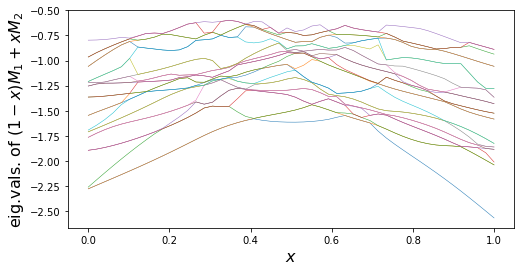

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
for idx in range(evals_mat.shape[1]):
    ax.plot(x_vec, np.real(evals_mat[:, idx]), lw=0.5)

ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"eig.vals. of $(1-x)M_1+xM_2$", fontsize=16)

The spectrum of the lowest 25 eigenvalues of the sparse matrix
$(1 − x)M_1+xM_2$, as a function of $x$, where $M_1$ and $M_2$ are two random matrices